# 1. Review: Monte Carlo Online Control

In this notebook we will apply Monte Carlo Online Control to design a trading policy for the stock in Chinese market.

We briefly review the algorithm for Monte Carlo Online Control:

Initialize $Q(s,a) = 0, N(s,a) = 0$, Set $\epsilon = 1, k = 1$; 

$\pi_k = \epsilon-Greedy(Q)$;

**Begin Loop**

Sample k-th episode ($s_{k,1},a_{k,1},r_{k,1},s_{k,2},a_{k,2},r_{k,2},\ldots$) given $\pi_k$;

$G_{k,t} = r_{k,t}+\gamma r_{k,{t+1}} + \gamma^2 r_{k,{t+2}} + \ldots$;

**For t = 1,...,T:**

If this is the first visit to $(s,a)$ in episode $k$,
let $N(s,a) = N(s,a)+1$, $Q(s,a) = Q(s,a) + (N(s,a))^{-1}\times(G_{k,t} - Q(s,a))$;

**End For**

$k = k+1$, $\epsilon = 1/k$;

$\pi_k = \epsilon-Greedy(Q)$;

**End Loop**

# 2. Implementation

## 2.1 Load data

In [1]:
import tushare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from single_stock_pi import SingleStockPI

In [2]:
pro = tushare.pro_api()
ts_code_list = pro.stock_basic(exchange='', list_status='L', fields='ts_code')['ts_code'][:100]

def download_data(ts_code_list):
    for ts_code in ts_code_list:
        start_date = '20100101'
        end_date = '20200101'
        df = tushare.pro_bar(ts_code=ts_code, adj='qfq', start_date=start_date, end_date=end_date)
        df.to_csv('./data/' + ts_code, mode = 'w')
    print("done")
    
def load_data(ts_code):
    filepath = './data/' + ts_code
    df = pd.read_csv(filepath)
    return df

In [3]:
# load data and reverse the time series
ts_code = '000002.SZ'
df = load_data(ts_code)
df = df.set_index(df.index[::-1]).sort_index()

## 2.2 Data Preprocess

We need to design a discretization function that transforms the K-dimensional features into an interger that represents the current state $s$.

In [4]:
def compute_split_list(features, alphas_list):
    """
    Function that compute the split list for discretization
    
    Input:
    features: N * K numpy array, N obs, K features 
              NOTE: Here features should be data in the training set.
              
    alphas_list: [alphas[1], ..., alphas[K]]
              each alphas[i] is an array of spliting quantile for the i-th feature
    """
    if len(np.shape(features)) == 1:
        features = np.matrix(features).T
    else:
        features = np.matrix(features)
    assert features.shape[1] == len(alphas_list)
    N, K = features.shape
    splits_list = []
    for f_id in range(K):
        splits_list.append([-np.inf] + [np.quantile(features[:,f_id],alpha) for alpha in alphas_list[f_id]] 
                            + [np.inf])
    return splits_list
    
def discretize(features, splits_list):
    """
    Function that transforms the features matrix into discrete state
    
    Input:
    Features: N * K numpy array, N obs, K features
    split_list: [splits[1], ..., splits[K]]
            each splits[i] is an array of spliting position for the i-th feature
    """
    if len(np.shape(features)) == 1:
        features = np.matrix(features).T
    else:
        features = np.matrix(features)
    assert features.shape[1] == len(splits_list)
    N, K = features.shape
    num_group_list = np.array([len(splits) - 1 for splits in splits_list])
    discrete_features = np.zeros_like(features, dtype = np.int)
    for f_id in range(K):
        discrete_features[:,f_id] = np.digitize(features[:,f_id], splits_list[f_id]) - 1
    S = np.zeros(N)
    if K == 1:
        S = np.array(discrete_features[:,0]).squeeze()
    else:
        S = np.array(discrete_features @ np.insert(np.cumprod(num_group_list[:-1]),0,1)).squeeze()
    return S

Apply random samples to validate the efficacy of function `discretize`.

[[-inf, 0.24293040355433565, 0.488998031705749, 0.7489711934616732, inf], [-inf, 0.24990388609953232, 0.49746013931918, 0.7522388579812096, inf]]


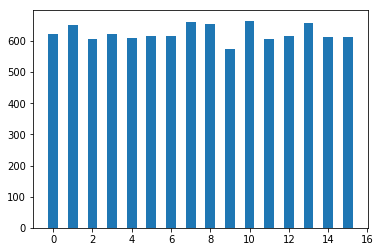

In [5]:
rand_data = np.random.rand(20000).reshape((10000,2))
rand_alphas_list = [[0.25,0.5,0.75],[0.25,0.5,0.75]]
rand_split = compute_split_list(rand_data, rand_alphas_list)
print(rand_split)
m = discretize(rand_data, rand_split)
plt.hist(m, bins = np.arange(-0.5,16.5,1),rwidth = 0.5)
plt.show()

Do discretization for stock data with multiple features 

In [6]:
df['1_day_pct_chg'] = df['close'].pct_change(1)
df['5_day_pct_chg'] = df['close'].pct_change(5)
features = df[{"1_day_pct_chg", "5_day_pct_chg"}].to_numpy()[5:]
features.shape

(2271, 2)

Compute Split points for stock data:

In [7]:
training_set_size = 2000
features_train = features[:training_set_size,:]
alphas_list = [[0.25,0.5,0.75],[0.25,0.5,0.75]]
split_list = compute_split_list(features_train, alphas_list)
split_list

[[-inf,
  -0.02894802954537684,
  0.0006953474445621222,
  0.031767535502564226,
  inf],
 [-inf,
  -0.012615851489540336,
  -0.0004074703221155773,
  0.011455619467034661,
  inf]]

compute state id:

In [8]:
S = discretize(features, split_list)[:-1]

visualize the distribution of S, make sure every state has enough data.

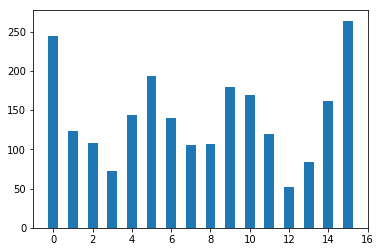

In [9]:
plt.hist(S, bins = np.arange(-0.5,16.5,1), rwidth = 0.5)
plt.show()

## 2.3 Implementation of MCOC

$S = \{0,1,...,15\}$, $A = \{0(\text{zero position}), 1(\text{full position})\}$

In [10]:
numS = 16
numA = 2
next_log_return = np.log(1+df['pct_chg'].shift(-1)/100)[5:-1].to_numpy()

def epsilon_greedy(s_episode, epsilon, Q_SA):
    # helper function that computes the epsilon-greedy policy
    
    indicators = np.random.binomial(1, epsilon, size = len(s_episode))
    a_argmax = np.argmax(Q_SA[s_episode,:], axis = 1)
    a_rand = np.random.randint(numA, size = len(s_episode))
    a_episode = a_argmax
    a_episode[indicators == 1] = a_rand[indicators == 1]
    
    return a_episode
    
def Monte_Carlo_control(S, next_log_return, gamma, episode_length):
    # learn trading policy using Monte Carlo method
    
    N_SA = np.zeros((numS, numA))
    Q_SA = np.zeros((numS, numA))
    log_returns = np.array([])
    
    gamma_power_list = np.logspace(0, episode_length, num=episode_length+1, base=gamma)
    epsilon, k = 1, 1
    
    while k*episode_length <= len(S):
        s_episode = S[(k-1)*episode_length:k*episode_length]
        a_episode = epsilon_greedy(s_episode, epsilon, Q_SA)
        r_episode = a_episode * next_log_return[(k-1)*episode_length:k*episode_length]
        log_returns = np.append(log_returns,r_episode)
        
        sa_set = set()
        for idx in range(episode_length):
            s, a = s_episode[idx], a_episode[idx]
            G_sa = np.sum(r_episode[idx:] * gamma_power_list[:-(idx+1)])
            if (s, a) not in sa_set:
                sa_set.add((s,a))
                N_SA[s,a] += 1
                Q_SA[s,a] = Q_SA[s,a] + (G_sa - Q_SA[s,a])/N_SA[s,a]
                
        k = k + 1
        epsilon = 1/k
    
    s_episode = S[(k-1)*episode_length:]
    a_episode = epsilon_greedy(s_episode, epsilon, Q_SA)
    r_episode = a_episode * next_log_return[(k-1)*episode_length:]
    
    log_returns = np.append(log_returns,r_episode)
    
    return log_returns

In [11]:
policy_log_returns = Monte_Carlo_control(S, next_log_return, gamma = 0.95, episode_length = 20)

Performance in the first year:

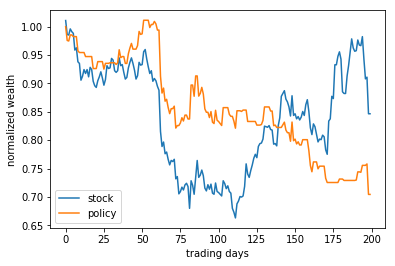

In [12]:
def plot1():
    plt.plot(np.exp(np.cumsum(next_log_return[:200])))
    plt.plot(np.exp(np.cumsum(policy_log_returns[:200])))
    plt.legend(["stock","policy"])
    plt.xlabel('trading days')
    plt.ylabel('normalized wealth')
    plt.show()
plot1()

Performance after the 1500 trading days:

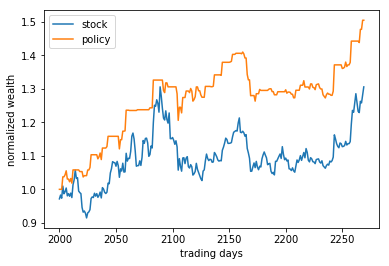

In [13]:
def plot2():
    days = range(training_set_size, training_set_size + len(policy_log_returns[training_set_size:]))
    plt.plot(days, np.exp(np.cumsum(next_log_return[training_set_size:])))
    plt.plot(days, np.exp(np.cumsum(policy_log_returns[training_set_size:])))
    plt.legend(["stock","policy"])
    plt.xlabel('trading days')
    plt.ylabel('normalized wealth')
    plt.show()
plot2()

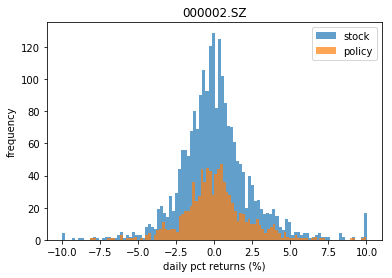

In [14]:
def plot3():
    plt.hist(100*(np.exp(next_log_return)-1), bins = 100, alpha = 0.7)
    plt.hist(100*(np.exp(policy_log_returns[policy_log_returns!=0])-1), bins = 100, alpha = 0.7)
    plt.legend(["stock","policy"])
    plt.xlabel('daily pct returns (%)')
    plt.ylabel('frequency')
    plt.title(ts_code)
    plt.show()
plot3()

# 3 Test the performance of MCOC on multiple stocks 

In [15]:
stock_return_list = np.array([])
policy_return_list = np.array([])
for ts_code in ts_code_list:
    if ts_code == '000029.SZ':
        # 停牌
        continue
    df = load_data(ts_code)
    df = df.set_index(df.index[::-1]).sort_index()
    
    df['1_day_pct_chg'] = df['close'].pct_change(1)
    df['5_day_pct_chg'] = df['close'].pct_change(5)
    features = df[{"1_day_pct_chg", "5_day_pct_chg"}].to_numpy()[5:]
    
    training_set_size = len(df) - 200
    features_train = features[:training_set_size,:]
    alphas_list = [[0.25,0.5,0.75],[0.25,0.5,0.75]]
    split_list = compute_split_list(features_train, alphas_list)
    S = discretize(features, split_list)[:-1]
    
    numS = 16
    numA = 2
    
    next_log_return = np.log(1+df['pct_chg'].shift(-1)/100)[5:-1].to_numpy()
    policy_log_returns = Monte_Carlo_control(S, next_log_return, gamma = 0.95, episode_length = 20)
    
    stock_return_test = np.exp(np.sum(next_log_return[training_set_size:]))
    policy_return_test = np.exp(np.sum(policy_log_returns[training_set_size:]))
    stock_return_list = np.append(stock_return_list,stock_return_test)
    policy_return_list = np.append(policy_return_list,policy_return_test)

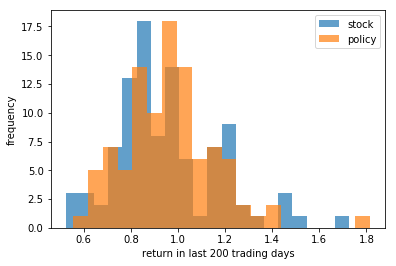

In [16]:
plt.hist(stock_return_list, bins = 20, alpha = 0.7)
plt.hist(policy_return_list, bins = 20, alpha = 0.7)
plt.legend(["stock","policy"])
plt.xlabel('return in last 200 trading days')
plt.ylabel('frequency')
plt.show()

Winning Rate:

In [17]:
sum(np.array(stock_return_list) < np.array(policy_return_list))/len(stock_return_list)

0.5656565656565656

Mean Excess Return:

In [18]:
np.mean(policy_return_list-stock_return_list)

0.016312598446038468